In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima.arima.utils import ndiffs, nsdiffs
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from datetime import timedelta
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
import itertools

Loading in data

In [2]:
data = 'data/Chicago-Crime_2001.csv'
df_2001 = pd.read_csv(data)

In [3]:
data = 'data/Chicago-Crime_2002.csv'
df_2002 = pd.read_csv(data)

In [4]:
data = 'data/Chicago-Crime_2003.csv'
df_2003 = pd.read_csv(data)

In [5]:
data = 'data/Chicago-Crime_2004.csv'
df_2004 = pd.read_csv(data)

In [6]:
data = 'data/Chicago-Crime_2005.csv'
df_2005 = pd.read_csv(data)

In [7]:
data = 'data/Chicago-Crime_2006.csv'
df_2006 = pd.read_csv(data)

In [8]:
data = 'data/Chicago-Crime_2007.csv'
df_2007 = pd.read_csv(data)

In [9]:
data = 'data/Chicago-Crime_2008.csv'
df_2008 = pd.read_csv(data)

In [10]:
data = 'data/Chicago-Crime_2009.csv'
df_2009 = pd.read_csv(data)

In [11]:
data = 'data/Chicago-Crime_2010.csv'
df_2010 = pd.read_csv(data)

In [12]:
data = 'data/Chicago-Crime_2011.csv'
df_2011 = pd.read_csv(data)

In [13]:
data = 'data/Chicago-Crime_2012.csv'
df_2012 = pd.read_csv(data)

In [14]:
data = 'data/Chicago-Crime_2013.csv'
df_2013 = pd.read_csv(data)

In [15]:
data = 'data/Chicago-Crime_2014.csv'
df_2014 = pd.read_csv(data)

In [16]:
data = 'data/Chicago-Crime_2015.csv'
df_2015 = pd.read_csv(data)

In [17]:
data = 'data/Chicago-Crime_2016.csv'
df_2016 = pd.read_csv(data)

In [18]:
data = 'data/Chicago-Crime_2017.csv'
df_2017 = pd.read_csv(data)

In [19]:
data = 'data/Chicago-Crime_2018.csv'
df_2018 = pd.read_csv(data)

In [20]:
data = 'data/Chicago-Crime_2019.csv'
df_2019 = pd.read_csv(data)

In [21]:
data = 'data/Chicago-Crime_2020.csv'
df_2020 = pd.read_csv(data)

In [22]:
data = 'data/Chicago-Crime_2021.csv'
df_2021 = pd.read_csv(data)

In [23]:
data = 'data/Chicago-Crime_2022.csv'
df_2022 = pd.read_csv(data)

In [24]:
dataframes = [
    df_2001, df_2002, df_2003, df_2004,
    df_2005, df_2006, df_2007, df_2008,
    df_2009, df_2010, df_2011, df_2012,
    df_2013, df_2014, df_2015, df_2016,
    df_2017, df_2018, df_2019, df_2020,
    df_2021, df_2022
]

In [25]:
df = pd.concat(dataframes)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7713109 entries, 0 to 238857
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ID                    int64  
 1   Date                  object 
 2   Primary Type          object 
 3   Description           object 
 4   Location Description  object 
 5   Arrest                bool   
 6   Domestic              bool   
 7   Beat                  int64  
 8   District              float64
 9   Ward                  float64
 10  Latitude              float64
 11  Longitude             float64
dtypes: bool(2), float64(4), int64(2), object(4)
memory usage: 662.0+ MB


Custom Functions

In [27]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [28]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [29]:
def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [30]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)



    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig

Transform the data to obtain a time series of the crime count per month using .size().
Check for and address null values.

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7713109 entries, 0 to 238857
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ID                    int64  
 1   Date                  object 
 2   Primary Type          object 
 3   Description           object 
 4   Location Description  object 
 5   Arrest                bool   
 6   Domestic              bool   
 7   Beat                  int64  
 8   District              float64
 9   Ward                  float64
 10  Latitude              float64
 11  Longitude             float64
dtypes: bool(2), float64(4), int64(2), object(4)
memory usage: 662.0+ MB


In [32]:
# Assuming 'Primary Type' is the column with crime types
theft_df = df[df['Primary Type'] == 'THEFT']
narcotics_df = df[df['Primary Type'] == 'NARCOTICS']

In [33]:
theft_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1626992 entries, 8 to 238836
Data columns (total 12 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   ID                    1626992 non-null  int64  
 1   Date                  1626992 non-null  object 
 2   Primary Type          1626992 non-null  object 
 3   Description           1626992 non-null  object 
 4   Location Description  1626209 non-null  object 
 5   Arrest                1626992 non-null  bool   
 6   Domestic              1626992 non-null  bool   
 7   Beat                  1626992 non-null  int64  
 8   District              1626988 non-null  float64
 9   Ward                  1504194 non-null  float64
 10  Latitude              1605887 non-null  float64
 11  Longitude             1605887 non-null  float64
dtypes: bool(2), float64(4), int64(2), object(4)
memory usage: 139.6+ MB


In [34]:
narcotics_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 746155 entries, 15 to 238615
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID                    746155 non-null  int64  
 1   Date                  746155 non-null  object 
 2   Primary Type          746155 non-null  object 
 3   Description           746155 non-null  object 
 4   Location Description  746154 non-null  object 
 5   Arrest                746155 non-null  bool   
 6   Domestic              746155 non-null  bool   
 7   Beat                  746155 non-null  int64  
 8   District              746154 non-null  float64
 9   Ward                  678832 non-null  float64
 10  Latitude              733594 non-null  float64
 11  Longitude             733594 non-null  float64
dtypes: bool(2), float64(4), int64(2), object(4)
memory usage: 64.0+ MB


In [35]:
theft_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1626992 entries, 8 to 238836
Data columns (total 12 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   ID                    1626992 non-null  int64  
 1   Date                  1626992 non-null  object 
 2   Primary Type          1626992 non-null  object 
 3   Description           1626992 non-null  object 
 4   Location Description  1626209 non-null  object 
 5   Arrest                1626992 non-null  bool   
 6   Domestic              1626992 non-null  bool   
 7   Beat                  1626992 non-null  int64  
 8   District              1626988 non-null  float64
 9   Ward                  1504194 non-null  float64
 10  Latitude              1605887 non-null  float64
 11  Longitude             1605887 non-null  float64
dtypes: bool(2), float64(4), int64(2), object(4)
memory usage: 139.6+ MB


In [36]:
# set datetime
theft_df['Date'] = pd.to_datetime(theft_df['Date'])
theft_df.set_index('Date', inplace=True)

# Group by month and count occurrences
theft_df = theft_df.groupby(pd.Grouper(freq='M')).size()

# Display the resulting time series
print(theft_df)

C:\Users\James\AppData\Local\Temp\ipykernel_27412\3557851281.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  theft_df['Date'] = pd.to_datetime(theft_df['Date'])


Date
2001-01-31    7867
2001-02-28    6669
2001-03-31    7766
2001-04-30    7702
2001-05-31    8420
              ... 
2022-08-31    5244
2022-09-30    5117
2022-10-31    5242
2022-11-30    4717
2022-12-31    4413
Freq: M, Length: 264, dtype: int64


In [37]:
# set datetime
narcotics_df['Date'] = pd.to_datetime(narcotics_df['Date'])
narcotics_df.set_index('Date', inplace=True)

# Group by month and count occurrences
narcotics_df = narcotics_df.groupby(pd.Grouper(freq='M')).size()

# Display the resulting time series
print(narcotics_df)

C:\Users\James\AppData\Local\Temp\ipykernel_27412\1756202785.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  narcotics_df['Date'] = pd.to_datetime(narcotics_df['Date'])


Date
2001-01-31    4714
2001-02-28    4369
2001-03-31    4862
2001-04-30    4044
2001-05-31    4038
              ... 
2022-08-31     420
2022-09-30     379
2022-10-31     358
2022-11-30     339
2022-12-31     325
Freq: M, Length: 264, dtype: int64


C:\Users\James\AppData\Local\Temp\ipykernel_27412\1756202785.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  narcotics_df['Date'] = pd.to_datetime(narcotics_df['Date'])


In [38]:
theft_df.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 264 entries, 2001-01-31 to 2022-12-31
Freq: M
Series name: None
Non-Null Count  Dtype
--------------  -----
264 non-null    int64
dtypes: int64(1)
memory usage: 4.1 KB


In [39]:
narcotics_df.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 264 entries, 2001-01-31 to 2022-12-31
Freq: M
Series name: None
Non-Null Count  Dtype
--------------  -----
264 non-null    int64
dtypes: int64(1)
memory usage: 4.1 KB


In [40]:
# Check for null values in the time series
null_values = narcotics_df.isnull().sum()
print(null_values)

0


In [41]:
# Check for null values in the time series
null_values = theft_df.isnull().sum()
print(null_values)

0


<Axes: xlabel='Date'>

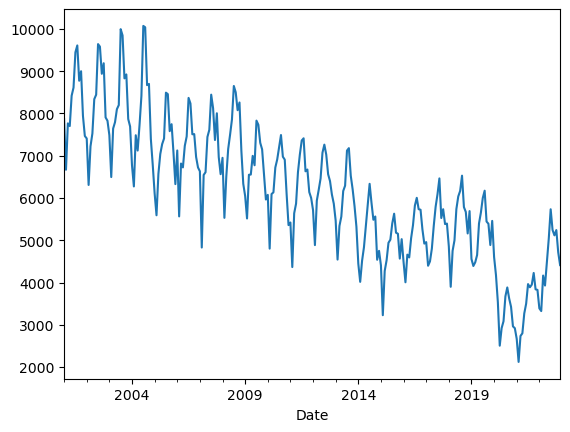

In [42]:
theft_df.plot()

<Axes: xlabel='Date'>

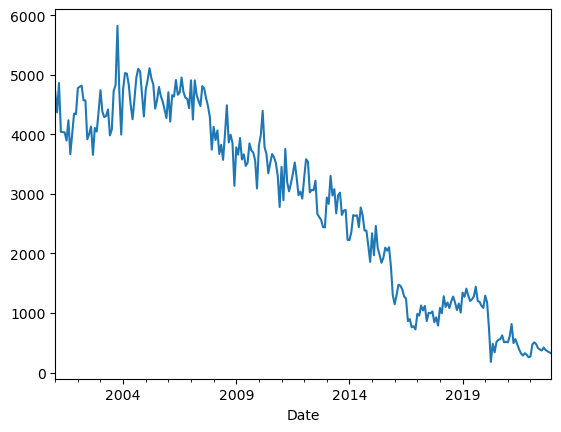

In [43]:
narcotics_df.plot()

Decompose the Time series to detect seasonality and decide whether to use a seasonal model or not

In [44]:
# How big is the seasonal component
decomp = tsa.seasonal_decompose(theft_df)
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min()

# How big is the seasonal component relative to the time series?
print(f"The seasonal component is {seasonal_delta} which is ~{seasonal_delta/(theft_df.max()-theft_df.min()) * 100 :.2f}% of the variation in time series.")

The seasonal component is 2549.988095238095 which is ~32.08% of the variation in time series.


Theft is seasonal

In [45]:
# How big is the seasonal component
decomp = tsa.seasonal_decompose(narcotics_df)
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min()

# How big is the seasonal component relative to the time series?
print(f"The seasonal component is {seasonal_delta} which is ~{seasonal_delta/(narcotics_df.max()-narcotics_df.min()) * 100 :.2f}% of the variation in time series.")

The seasonal component is 550.6626984126985 which is ~9.76% of the variation in time series.


Narcotics is also seasonal to a less degree. 

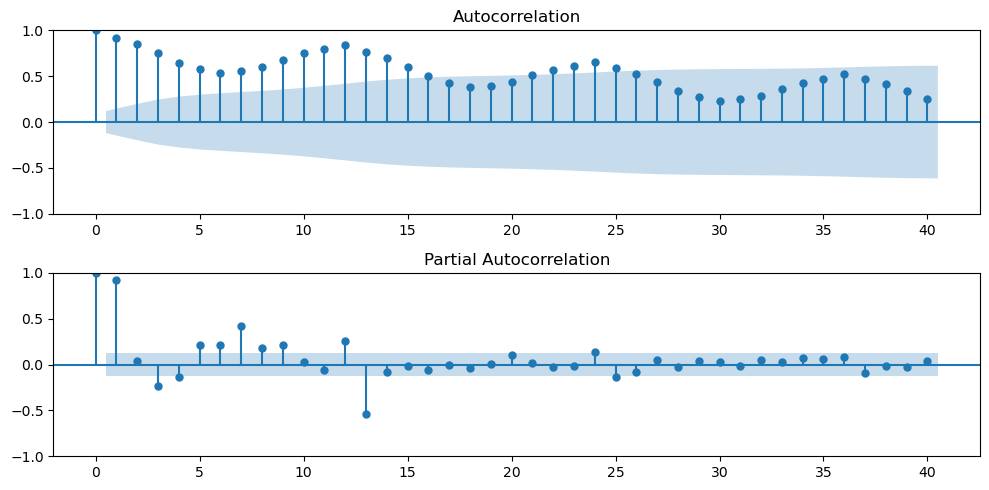

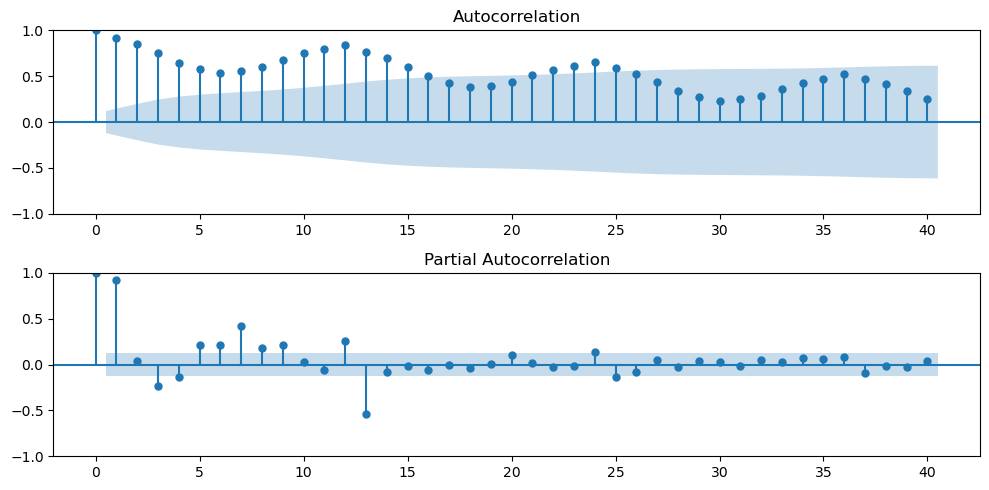

In [46]:
plot_acf_pacf(theft_df)

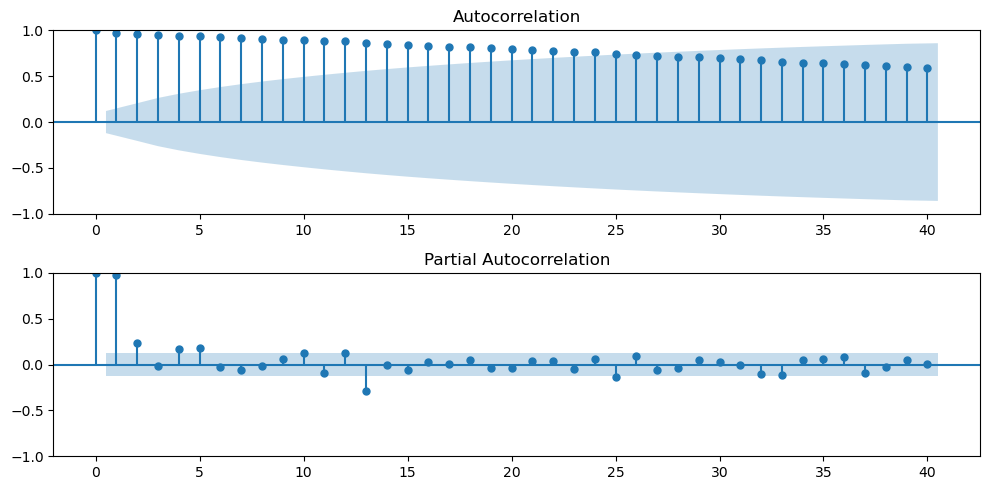

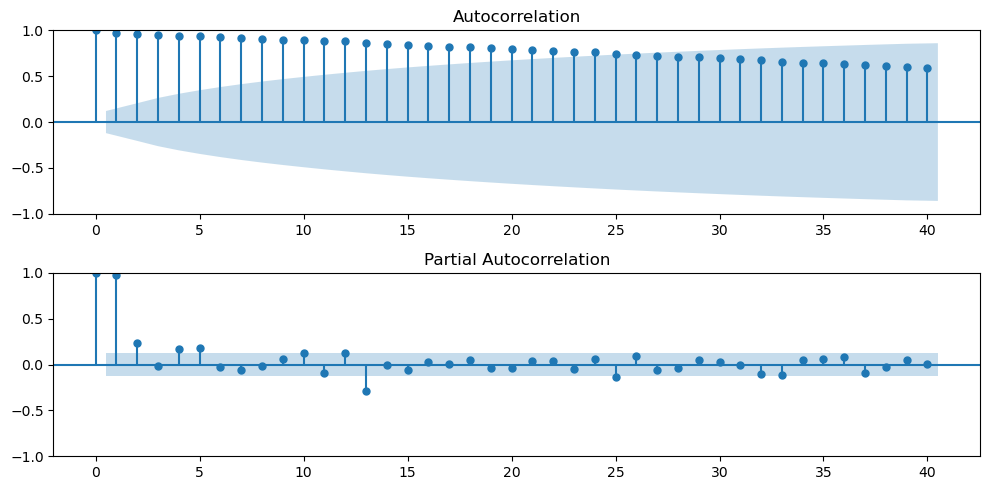

In [47]:
plot_acf_pacf(narcotics_df)

In [48]:
get_adfuller_results(narcotics_df)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,0.265472,12,251,0.975704,0.05,False


In [49]:
get_adfuller_results(theft_df)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-1.393935,13,250,0.58518,0.05,False


Differencing the data to make stationary

In [50]:
d = ndiffs(theft_df)
print(d)

1


In [51]:
d = ndiffs(narcotics_df)
print(d)

1


In [52]:
theft_df_diff = theft_df.diff()
narcotics_df_diff = narcotics_df.diff()

In [53]:
theft_df_diff.head(5)

Date
2001-01-31       NaN
2001-02-28   -1198.0
2001-03-31    1097.0
2001-04-30     -64.0
2001-05-31     718.0
Freq: M, dtype: float64

In [54]:
narcotics_df_diff.head(5)

Date
2001-01-31      NaN
2001-02-28   -345.0
2001-03-31    493.0
2001-04-30   -818.0
2001-05-31     -6.0
Freq: M, dtype: float64

In [55]:
# Dropping nulls
narcotics_df_diff = narcotics_df_diff.dropna()
theft_df_diff = theft_df_diff.dropna()

In [56]:
# Data is now stationary
get_adfuller_results(theft_df_diff)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-3.953728,12,250,0.001673,0.05,True


In [57]:
# Data is now stationary
get_adfuller_results(narcotics_df_diff)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-5.393766,11,251,0.000003,0.05,True


In [58]:
# Train-test split for narcotics
narcotics_train = narcotics_df_diff.iloc[:-6]
narcotics_test = narcotics_df_diff.iloc[-6:]

# Train-test split for theft
theft_train = theft_df_diff.iloc[:-6]
theft_test = theft_df_diff.iloc[-6:]

# Display the lengths of the training and testing sets
print("Narcotics - Training set length:", len(narcotics_train))
print("Narcotics - Testing set length:", len(narcotics_test))

print("\nTheft - Training set length:", len(theft_train))
print("Theft - Testing set length:", len(theft_test))


Narcotics - Training set length: 257
Narcotics - Testing set length: 6

Theft - Training set length: 257
Theft - Testing set length: 6


In [59]:
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 1  # nonseasonal MA

# Orders for seasonal components
P = 1  # Seasonal AR
D = 1  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

narcotics_sarima = tsa.ARIMA(narcotics_train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Obtain summary
narcotics_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                                y   No. Observations:                  257
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1693.540
Date:                          Wed, 17 Jan 2024   AIC                           3397.079
Time:                                  21:17:42   BIC                           3414.565
Sample:                              02-28-2001   HQIC                          3404.121
                                   - 06-30-2022                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1650      0.040     -4.148      0.000      -0.243      -0.087
ma.L1         -1.0000      0.071    -14.018      0.000      -1.140      -0.860
ar.S.L12       0.1383      0.084      1.637      0.102      -0.027       0.304
ma.S.L12      -0.8621      0.080    -10.787      0.000      -1.019      -0.705
sigma2      5.773e+04   1.24e-06   4.67e+10      0.000    5.77e+04    5.77e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               127.78
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.38   Skew:                            -1.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.08e+25. Standard errors may be unstable.
"""

In [60]:
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 1  # nonseasonal MA

# Orders for seasonal components
P = 1  # Seasonal AR
D = 1  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

theft_sarima = tsa.ARIMA(theft_train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Obtain summary
theft_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                                y   No. Observations:                  257
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1764.205
Date:                          Wed, 17 Jan 2024   AIC                           3538.411
Time:                                  21:17:43   BIC                           3555.897
Sample:                              02-28-2001   HQIC                          3545.453
                                   - 06-30-2022                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2419      0.047     -5.127      0.000      -0.334      -0.149
ma.L1         -1.0000      0.069    -14.418      0.000      -1.136      -0.864
ar.S.L12       0.1219      0.107      1.139      0.255      -0.088       0.332
ma.S.L12      -0.7379      0.072    -10.296      0.000      -0.878      -0.597
sigma2      1.052e+05   6.59e-07    1.6e+11      0.000    1.05e+05    1.05e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                42.98
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                            -0.32
Prob(H) (two-sided):                  0.55   Kurtosis:                         4.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.28e+26. Standard errors may be unstable.
"""

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 267.789
- MSE = 108,340.996
- RMSE = 329.152
- R^2 = 0.381
- MAPE = 82.68%


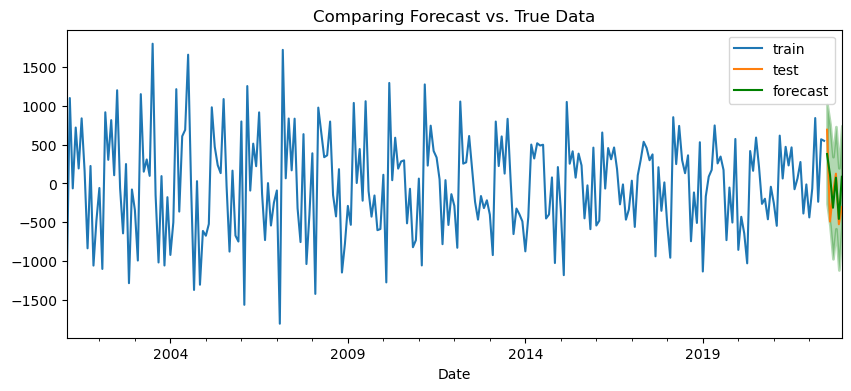

In [61]:
# Obtain summary of forecast as dataframe
forecast_df = theft_sarima.get_forecast(len(theft_test)).summary_frame()
# Plot the forecast with true values
plot_forecast(theft_train, theft_test, forecast_df)
# Obtain metrics
regression_metrics_ts(theft_test, forecast_df["mean"])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 63.280
- MSE = 5,627.075
- RMSE = 75.014
- R^2 = -5.974
- MAPE = 331.42%


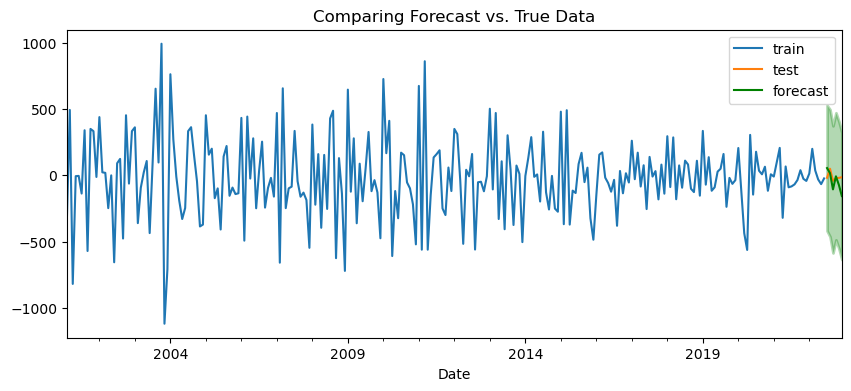

In [62]:
# Obtain summary of forecast as dataframe
forecast_df = narcotics_sarima.get_forecast(len(narcotics_test)).summary_frame()
# Plot the forecast with true values
plot_forecast(narcotics_train, narcotics_test, forecast_df)
# Obtain metrics
regression_metrics_ts(narcotics_test, forecast_df["mean"])

In [63]:
theft_auto_model = pm.auto_arima(theft_train, seasonal=True,
        start_p=0, d=1, start_q=0, max_p=5, max_q=5, start_P=0, start_Q=0, max_P=5, max_D=1, max_Q=5,
        m=12)

In [64]:
theft_auto_model

ARIMA(order=(3, 1, 0), scoring_args={}, seasonal_order=(1, 0, 4, 12),
      suppress_warnings=True)

In [65]:
narcotics_auto_model = pm.auto_arima(narcotics_train, seasonal=True,
        start_p=0, d=1, start_q=0, max_p=5, max_q=5, start_P=0, start_Q=0, max_P=5, max_D=1, max_Q=5,
        m=12)

In [66]:
narcotics_auto_model

ARIMA(order=(5, 1, 0), scoring_args={}, seasonal_order=(4, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

Tuning Models

In [68]:
# Orders for non seasonal components
p = 5  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 0  # nonseasonal MA

# Orders for seasonal components
P = 4  # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

narcotics_sarima = tsa.ARIMA(narcotics_train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Obtain summary
narcotics_sarima.summary()

C:\Users\James\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  257
Model:             ARIMA(5, 1, 0)x(4, 0, [1], 12)   Log Likelihood               -1787.816
Date:                            Wed, 17 Jan 2024   AIC                           3597.633
Time:                                    21:25:53   BIC                           3636.630
Sample:                                02-28-2001   HQIC                          3613.317
                                     - 06-30-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9769      0.041    -23.667      0.000      -1.058      -0.896
ar.L2         -0.8361      0.069    -12.118      0.000      -0.971      -0.701
ar.L3         -0.7024      0.079     -8.862      0.000      -0.858      -0.547
ar.L4         -0.5696      0.079     -7.229      0.000      -0.724      -0.415
ar.L5         -0.2385      0.061     -3.922      0.000      -0.358      -0.119
ar.S.L12       0.8258      0.168      4.908      0.000       0.496       1.156
ar.S.L24      -0.0405      0.097     -0.418      0.676      -0.230       0.149
ar.S.L36      -0.0857      0.104     -0.821      0.412      -0.290       0.119
ar.S.L48       0.2001      0.087      2.295      0.022       0.029       0.371
ma.S.L12      -0.5521      0.180     -3.068      0.002      -0.905      -0.199
sigma2      6.555e+04   4762.280     13.764      0.000    5.62e+04    7.49e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                79.11
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               0.32   Skew:                            -0.78
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 267.789
- MSE = 108,340.996
- RMSE = 329.152
- R^2 = 0.381
- MAPE = 82.68%


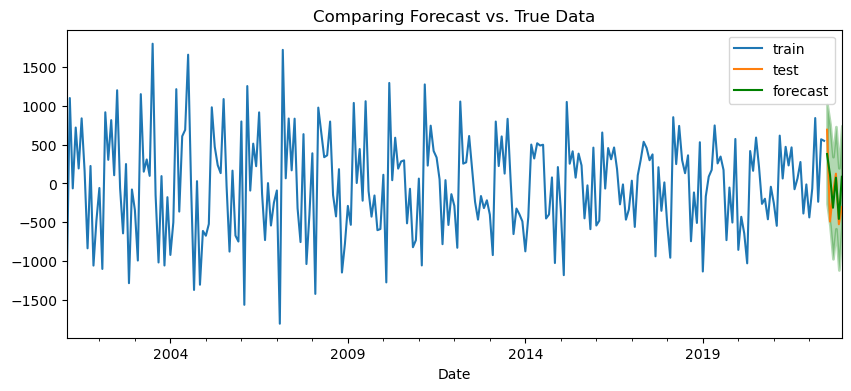

In [69]:
# Obtain summary of forecast as dataframe
forecast_df = theft_sarima.get_forecast(len(theft_test)).summary_frame()
# Plot the forecast with true values
plot_forecast(theft_train, theft_test, forecast_df)
# Obtain metrics
regression_metrics_ts(theft_test, forecast_df["mean"])

In [71]:
# Orders for non seasonal components
p = 3  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 0  # nonseasonal MA

# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 4  # Seasonal MA
m = 12 # Seasonal period

theft_sarima = tsa.ARIMA(theft_train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Obtain summary
theft_sarima.summary()

C:\Users\James\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                          SARIMAX Results                                          
===================================================================================================
Dep. Variable:                                           y   No. Observations:                  257
Model:             ARIMA(3, 1, 0)x(1, 0, [1, 2, 3, 4], 12)   Log Likelihood               -1896.733
Date:                                     Wed, 17 Jan 2024   AIC                           3811.467
Time:                                             21:26:25   BIC                           3843.373
Sample:                                         02-28-2001   HQIC                          3824.300
                                              - 06-30-2022                                         
Covariance Type:                                       opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9314      0.049    -19.040      0.000      -1.027      -0.835
ar.L2         -0.5778      0.065     -8.857      0.000      -0.706      -0.450
ar.L3         -0.2248      0.057     -3.932      0.000      -0.337      -0.113
ar.S.L12       0.9997      0.003    365.918      0.000       0.994       1.005
ma.S.L12      -0.6203      0.105     -5.911      0.000      -0.826      -0.415
ma.S.L24      -0.2123      0.054     -3.933      0.000      -0.318      -0.107
ma.S.L36       0.0075      0.062      0.121      0.904      -0.114       0.129
ma.S.L48      -0.1339      0.069     -1.928      0.054      -0.270       0.002
sigma2       1.36e+05    3.7e-07   3.68e+11      0.000    1.36e+05    1.36e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):                 5.75
Prob(Q):                              0.62   Prob(JB):                         0.06
Heteroskedasticity (H):               1.10   Skew:                            -0.28
Prob(H) (two-sided):                  0.66   Kurtosis:                         3.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.01e+26. Standard errors may be unstable.
"""

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 197.206
- MSE = 68,469.130
- RMSE = 261.666
- R^2 = 0.609
- MAPE = 66.11%


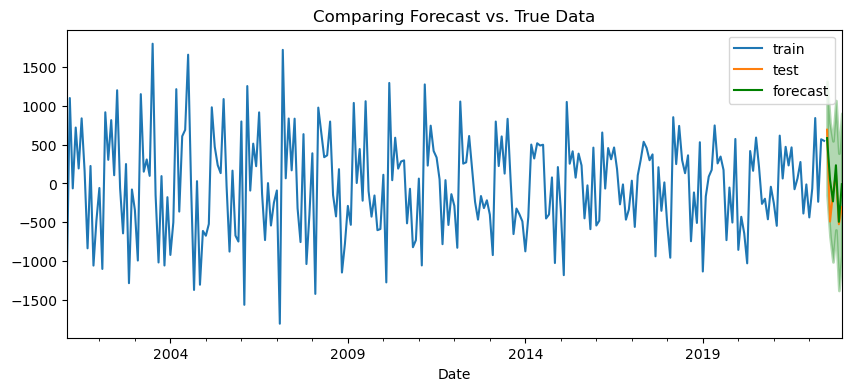

In [72]:
# Obtain summary of forecast as dataframe
forecast_df = theft_sarima.get_forecast(len(theft_test)).summary_frame()
# Plot the forecast with true values
plot_forecast(theft_train, theft_test, forecast_df)
# Obtain metrics
regression_metrics_ts(theft_test, forecast_df["mean"])

In [73]:
theft_sarima.get_forecast(steps=6).summary_frame()

y,mean,mean_se,mean_ci_lower,mean_ci_upper
2022-07-31,582.058100,372.775452,-148.568360,1312.684559
2022-08-31,47.709838,373.652160,-684.634938,780.054613
2022-09-30,-231.100141,396.801450,-1008.816693,546.616410
2022-10-31,233.296969,424.136869,-597.996019,1064.589957
2022-11-30,-493.923039,449.991154,-1375.889495,388.043417
2022-12-31,-9.890146,464.743977,-920.771603,900.991311


In [74]:
narcotics_sarima.get_forecast(steps=6).summary_frame()

y,mean,mean_se,mean_ci_lower,mean_ci_upper
2022-07-31,83.150559,256.027403,-418.653930,584.955048
2022-08-31,17.325234,256.095698,-484.613112,519.263579
2022-09-30,12.887353,258.638284,-494.034368,519.809075
2022-10-31,-9.441379,261.119057,-521.225327,502.342570
2022-11-30,7.447193,264.275080,-510.522445,525.416830
2022-12-31,-35.534766,281.304338,-586.881138,515.811605
